Loading train/test splits...
X_train shape: (3392, 15)
X_test shape: (848, 15)

--- Seed 0 ---


Choosing lambda with cross-validation: 100%|██████████| 5/5 [00:25<00:00,  5.07s/it]


--- Seed 1 ---


Choosing lambda with cross-validation: 100%|██████████| 5/5 [00:26<00:00,  5.31s/it]


--- Seed 2 ---


Choosing lambda with cross-validation: 100%|██████████| 5/5 [00:26<00:00,  5.39s/it]


--- Seed 3 ---


Choosing lambda with cross-validation: 100%|██████████| 5/5 [00:24<00:00,  4.97s/it]


--- Seed 4 ---


Choosing lambda with cross-validation: 100%|██████████| 5/5 [00:23<00:00,  4.77s/it]


--- Seed 5 ---


Choosing lambda with cross-validation: 100%|██████████| 5/5 [00:27<00:00,  5.44s/it]


--- Seed 6 ---


Choosing lambda with cross-validation: 100%|██████████| 5/5 [00:24<00:00,  4.98s/it]


--- Seed 7 ---


Choosing lambda with cross-validation: 100%|██████████| 5/5 [00:24<00:00,  4.85s/it]


--- Seed 8 ---


Choosing lambda with cross-validation: 100%|██████████| 5/5 [00:26<00:00,  5.26s/it]


--- Seed 9 ---


Choosing lambda with cross-validation: 100%|██████████| 5/5 [00:27<00:00,  5.55s/it]


--- Seed 10 ---


Choosing lambda with cross-validation: 100%|██████████| 5/5 [00:24<00:00,  4.85s/it]


--- Seed 11 ---


Choosing lambda with cross-validation: 100%|██████████| 5/5 [00:26<00:00,  5.24s/it]


--- Seed 12 ---


Choosing lambda with cross-validation: 100%|██████████| 5/5 [00:25<00:00,  5.16s/it]


--- Seed 13 ---


Choosing lambda with cross-validation: 100%|██████████| 5/5 [00:25<00:00,  5.08s/it]


--- Seed 14 ---


Choosing lambda with cross-validation: 100%|██████████| 5/5 [00:25<00:00,  5.05s/it]


--- Seed 15 ---


Choosing lambda with cross-validation: 100%|██████████| 5/5 [00:25<00:00,  5.12s/it]


--- Seed 16 ---


Choosing lambda with cross-validation: 100%|██████████| 5/5 [00:25<00:00,  5.18s/it]


--- Seed 17 ---


Choosing lambda with cross-validation: 100%|██████████| 5/5 [00:25<00:00,  5.15s/it]


--- Seed 18 ---


Choosing lambda with cross-validation: 100%|██████████| 5/5 [00:26<00:00,  5.35s/it]


--- Seed 19 ---


Choosing lambda with cross-validation: 100%|██████████| 5/5 [00:24<00:00,  5.00s/it]



=== Best Model Summary ===
Seed: 18
Best Lambda: 14.76002091425563
CV F1 Score: 0.4757
Test F1 Score: 0.4034

Classification Report (Best Seed):
              precision    recall  f1-score   support

           0       0.93      0.66      0.77       719
           1       0.28      0.73      0.40       129

    accuracy                           0.67       848
   macro avg       0.61      0.70      0.59       848
weighted avg       0.83      0.67      0.72       848



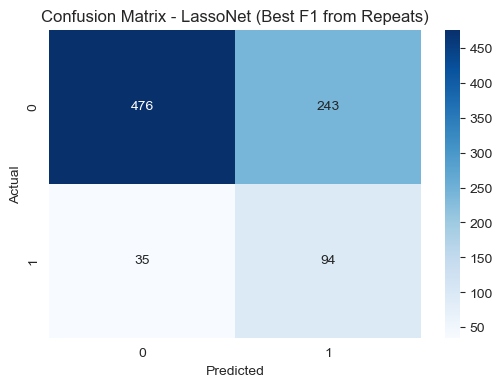

Selected Features (Best Model): tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True])
Saved best model to ../models/lassonet_best_model_seed_18.pkl
Saved summary to ../results/lassonet_repeated_subsampling_results.csv


In [5]:
# --- 03_lasso_net_classifier_with_subsampling_repeated.ipynb ---

import numpy as np
import pandas as pd
from lassonet import LassoNetClassifierCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
from sklearn.utils import resample

# 1. Load preprocessed data
print("Loading train/test splits...")
X_train = np.load("../../data/splits/X_train.npy")
y_train = np.load("../../data/splits/y_train.npy")
X_test = np.load("../../data/splits/X_test.npy")
y_test = np.load("../../data/splits/y_test.npy")

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}\n")

# 2. Repeated Subsampling and Training
results_list = []
all_models = []
all_preds = []
all_f1s = []

for seed in range(20):
    print(f"--- Seed {seed} ---")

    # Subsampling
    X_minority = X_train[y_train == 1]
    y_minority = y_train[y_train == 1]
    X_majority = X_train[y_train == 0]
    y_majority = y_train[y_train == 0]

    X_majority_downsampled, y_majority_downsampled = resample(
        X_majority, y_majority,
        replace=False,
        n_samples=len(X_minority),
        random_state=seed
    )

    X_resampled = np.vstack((X_majority_downsampled, X_minority))
    y_resampled = np.hstack((y_majority_downsampled, y_minority))

    model = LassoNetClassifierCV()
    model.fit(X_resampled, y_resampled)

    y_test_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_test_pred)

    results_list.append({
        'seed': seed,
        'best_lambda': model.best_lambda_,
        'best_cv_score': model.best_cv_score_,
        'test_f1': f1
    })

    all_models.append(model)
    all_preds.append(y_test_pred)
    all_f1s.append(f1)

# 3. Best Model Selection
best_idx = np.argmax(all_f1s)
final_model = all_models[best_idx]
final_preds = all_preds[best_idx]
final_result = results_list[best_idx]

# 4. Report and Confusion Matrix
print("\n=== Best Model Summary ===")
print(f"Seed: {final_result['seed']}")
print(f"Best Lambda: {final_result['best_lambda']}")
print(f"CV F1 Score: {final_result['best_cv_score']:.4f}")
print(f"Test F1 Score: {final_result['test_f1']:.4f}\n")

print("Classification Report (Best Seed):")
print(classification_report(y_test, final_preds))

cm = confusion_matrix(y_test, final_preds)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - LassoNet (Best F1 from Repeats)")
plt.show()

# 5. Selected Features
print(f"Selected Features (Best Model): {final_model.best_selected_}")

# 6. Save Best Model
os.makedirs("../../models", exist_ok=True)
best_model_path = f"../models/lassonet_best_model_seed_{final_result['seed']}.pkl"
joblib.dump(final_model, best_model_path)
print(f"Saved best model to {best_model_path}")

# 7. Save Results Table
results_df = pd.DataFrame(results_list)
os.makedirs("../../results", exist_ok=True)
results_df.to_csv("../results/lassonet_repeated_subsampling_results.csv", index=False)
print("Saved summary to ../results/lassonet_repeated_subsampling_results.csv")